In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

import pandas_datareader.data as pd_web
from datetime import datetime
import yfinance as yf
yf.pdr_override()  # update pandas datareader (yahoo finance api)
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use('cyberpunk')
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from copy import deepcopy as dc
import time

device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(f"{device} 사용 가능합니다")

mps:0 사용 가능합니다


In [17]:
# df = pd.read_csv('./NVDA_110721_Final_1_fdr.csv', index_col=['Date'], usecols=['Date', 'Close'])
# df['Percentage Difference'] = df.pct_change() * 100
# df = df.drop('2011/07/21')

# df_X = dc(df[['Percentage Difference']])
# df_y = dc(df[['Percentage Difference']])

df = pd.read_csv('./NVDA_110721_Final_1_fdr.csv', index_col=['Date'])

df_X = dc(df[['Close']])
df_y = dc(df[['Close']])

df_X, df_y

(                 Close
 Date                  
 2011/07/21    3.675000
 2011/07/22    3.750000
 2011/07/25    3.690000
 2011/07/26    3.600000
 2011/07/27    3.465000
 ...                ...
 2021/07/14  198.414993
 2021/07/15  189.662506
 2021/07/16  181.610001
 2021/07/19  187.797501
 2021/07/20  186.119995
 
 [2516 rows x 1 columns],
                  Close
 Date                  
 2011/07/21    3.675000
 2011/07/22    3.750000
 2011/07/25    3.690000
 2011/07/26    3.600000
 2011/07/27    3.465000
 ...                ...
 2021/07/14  198.414993
 2021/07/15  189.662506
 2021/07/16  181.610001
 2021/07/19  187.797501
 2021/07/20  186.119995
 
 [2516 rows x 1 columns])

In [18]:
def create_sequences(X, y, seq_length):
    xs = []
    ys = []
    for i in range(len(X) - seq_length):
        _X = X.iloc[i : (i+seq_length)]
        _y = y.iloc[i + seq_length]
        xs.append(_X)
        ys.append(_y)
    return np.array(xs), np.array(ys)

#지도학습용 데이터로 변환
seq_length = 40
X, y = create_sequences(df_X, df_y, seq_length)

X.shape, y.shape

((2476, 40, 1), (2476, 1))

In [19]:
#학습용, 검증용, 시험용으로 분리
train_size = int(X.shape[0] * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train.shape, X_test.shape

((1980, 40, 1), (496, 40, 1))

In [20]:
# MinMax Scaling
scaler_x = MinMaxScaler()
scaler_x.fit(X_train.reshape((-1, 1)))
scaler_y = MinMaxScaler()
scaler_y.fit(y_train)

X_train = scaler_x.transform(X_train.reshape((-1, 1)))
y_train = scaler_y.transform(y_train)

X_test = scaler_x.transform(X_test.reshape((-1, 1)))
y_test = scaler_y.transform(y_test)

In [21]:
y_train

array([[0.01467732],
       [0.01352615],
       [0.01212318],
       ...,
       [0.58795603],
       [0.59022234],
       [0.56601198]])

In [22]:
def to_tensor(array):
    return torch.from_numpy(array).type('torch.FloatTensor')

X_train = to_tensor(X_train.reshape((-1, 40, 1)))
X_test = to_tensor(X_test.reshape((-1, 40, 1)))
y_train = to_tensor(y_train)
y_test = to_tensor(y_test)

In [23]:
display(X_train.shape, X_test.shape)
display(y_train.shape, y_test.shape)

torch.Size([1980, 40, 1])

torch.Size([496, 40, 1])

torch.Size([1980, 1])

torch.Size([496, 1])

In [24]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 300
verbose = 10
patience = 50

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [26]:
model = LSTM(input_dim=input_dim, 
             hidden_dim=hidden_dim, 
             output_dim=output_dim, 
             num_layers=num_layers)

criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [27]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    hist[t] = loss.item()

    if t % verbose == 0:
        print(f"Epoch {t}   L1LOSS:  {loss.item()}")

    if (t % patience == 0) & (t != 0):
        ## loss가 커졌다면 early stop
        if hist[t - patience] < hist[t] :
            print('\n Early Stopping')
            break

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    

training_time = time.time() - start_time
print(f"Training time: {training_time:.2f}s")

Epoch 0   L1LOSS:  0.24627476930618286
Epoch 10   L1LOSS:  0.02255416475236416
Epoch 20   L1LOSS:  0.048349469900131226
Epoch 30   L1LOSS:  0.05241042748093605
Epoch 40   L1LOSS:  0.034517861902713776
Epoch 50   L1LOSS:  0.01815543696284294
Epoch 60   L1LOSS:  0.02515139989554882
Epoch 70   L1LOSS:  0.017680564895272255
Epoch 80   L1LOSS:  0.016531068831682205
Epoch 90   L1LOSS:  0.01183027308434248
Epoch 100   L1LOSS:  0.0126297352835536
Epoch 110   L1LOSS:  0.024380216374993324
Epoch 120   L1LOSS:  0.041325535625219345
Epoch 130   L1LOSS:  0.0171368345618248
Epoch 140   L1LOSS:  0.018673216924071312
Epoch 150   L1LOSS:  0.012784220278263092

 Early Stopping
Training time: 18.62s


In [28]:
predict = pd.DataFrame(scaler_y.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler_y.inverse_transform(y_train.detach().numpy()))

# predict = pd.DataFrame(y_train_pred.detach().numpy())
# original = pd.DataFrame(y_train.detach().numpy())

In [29]:
predict

,0
0,3.542783
1,3.597945
2,3.621237
3,3.611667
4,3.581265
...,...
1975,42.691437
1976,42.835815
1977,42.934055
1978,42.975601


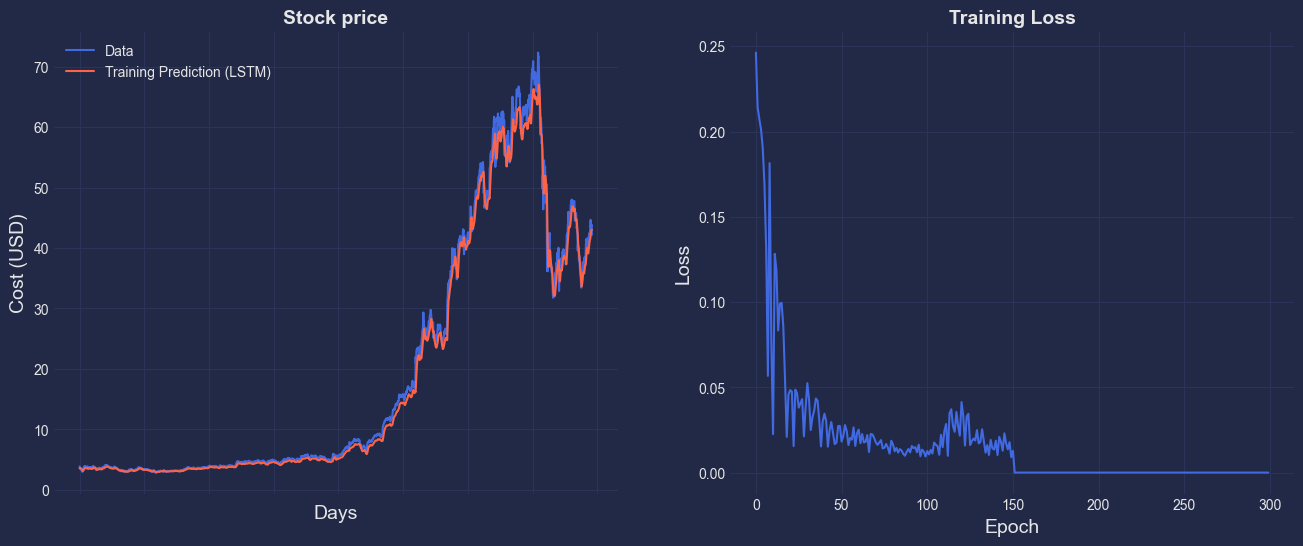

In [30]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [31]:
import math
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(X_test)

# invert predictions
y_train_pred = scaler_y.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler_y.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler_y.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler_y.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 1.42 RMSE
Test Score: 31.93 RMSE


In [32]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_length:len(y_train_pred)+seq_length, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+seq_length-1:len(df_X)-1, :] = y_test_pred

original = scaler_y.inverse_transform(df_X['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [34]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)

annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()